# Preprocessing for Ames Housing Dataset

## Prepare the Ames Housing Data for AutoML and final modeling.

## 1. Transforming the target variable (SalePrice)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
csv_path = "../data/AmesHousing.csv"

# Load CSV
df = pd.read_csv(csv_path)

# Quick check
print(df.head())

   Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0      1  526301100           20        RL         141.0     31770   Pave   
1      2  526350040           20        RH          80.0     11622   Pave   
2      3  526351010           20        RL          81.0     14267   Pave   
3      4  526353030           20        RL          93.0     11160   Pave   
4      5  527105010           60        RL          74.0     13830   Pave   

  Alley Lot Shape Land Contour  ... Pool Area Pool QC  Fence Misc Feature  \
0   NaN       IR1          Lvl  ...         0     NaN    NaN          NaN   
1   NaN       Reg          Lvl  ...         0     NaN  MnPrv          NaN   
2   NaN       IR1          Lvl  ...         0     NaN    NaN         Gar2   
3   NaN       Reg          Lvl  ...         0     NaN    NaN          NaN   
4   NaN       IR1          Lvl  ...         0     NaN  MnPrv          NaN   

  Misc Val Mo Sold Yr Sold Sale Type  Sale Condition  SalePrice  
0       

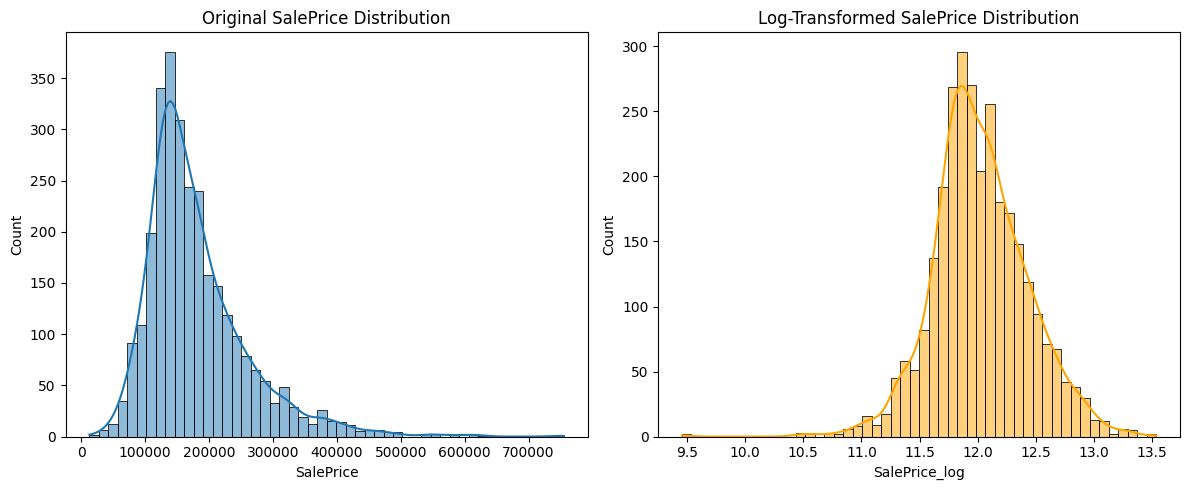

In [4]:
# Log-transform the target variable
df['SalePrice_log'] = np.log1p(df['SalePrice'])  # log1p handles zero values safely

# Quick visualization to see the effect
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.histplot(df['SalePrice'], kde=True, bins=50)
plt.title('Original SalePrice Distribution')

plt.subplot(1,2,2)
sns.histplot(df['SalePrice_log'], kde=True, bins=50, color='orange')
plt.title('Log-Transformed SalePrice Distribution')

plt.tight_layout()
plt.show()

## 2. Handling Missing Values

In [5]:
# Identify numeric and categorical columns
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# Optional: remove target variable from features
if 'SalePrice' in numeric_features:
    numeric_features.remove('SalePrice')

# Quick check
print("Numeric features:", numeric_features[:10], "...")
print("Categorical features:", categorical_features[:10], "...")


Numeric features: ['Order', 'PID', 'MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area'] ...
Categorical features: ['MS Zoning', 'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1'] ...


In [6]:
# For numeric features
for col in numeric_features:
    df[col] = df[col].fillna(df[col].median())

# For categorical features
for col in categorical_features:
    df[col] = df[col].fillna("Missing")


# Quick check to confirm
missing_summary = df.isnull().sum()[df.isnull().sum() > 0]
print("Remaining missing values:\n", missing_summary)


Remaining missing values:
 Series([], dtype: int64)


## 3. Categorical Feature Encoding

In [7]:
# List all categorical columns
for col in categorical_features:
    print(f"{col}: {df[col].unique()}\n")


MS Zoning: ['RL' 'RH' 'FV' 'RM' 'C (all)' 'I (all)' 'A (agr)']

Street: ['Pave' 'Grvl']

Alley: ['Missing' 'Pave' 'Grvl']

Lot Shape: ['IR1' 'Reg' 'IR2' 'IR3']

Land Contour: ['Lvl' 'HLS' 'Bnk' 'Low']

Utilities: ['AllPub' 'NoSewr' 'NoSeWa']

Lot Config: ['Corner' 'Inside' 'CulDSac' 'FR2' 'FR3']

Land Slope: ['Gtl' 'Mod' 'Sev']

Neighborhood: ['NAmes' 'Gilbert' 'StoneBr' 'NWAmes' 'Somerst' 'BrDale' 'NPkVill'
 'NridgHt' 'Blmngtn' 'NoRidge' 'SawyerW' 'Sawyer' 'Greens' 'BrkSide'
 'OldTown' 'IDOTRR' 'ClearCr' 'SWISU' 'Edwards' 'CollgCr' 'Crawfor'
 'Blueste' 'Mitchel' 'Timber' 'MeadowV' 'Veenker' 'GrnHill' 'Landmrk']

Condition 1: ['Norm' 'Feedr' 'PosN' 'RRNe' 'RRAe' 'Artery' 'PosA' 'RRAn' 'RRNn']

Condition 2: ['Norm' 'Feedr' 'PosA' 'PosN' 'Artery' 'RRNn' 'RRAe' 'RRAn']

Bldg Type: ['1Fam' 'TwnhsE' 'Twnhs' 'Duplex' '2fmCon']

House Style: ['1Story' '2Story' '1.5Fin' 'SFoyer' 'SLvl' '2.5Unf' '1.5Unf' '2.5Fin']

Roof Style: ['Hip' 'Gable' 'Mansard' 'Gambrel' 'Shed' 'Flat']

Roof Matl: ['Comp

In [8]:
from sklearn.preprocessing import OrdinalEncoder

# Define ordinal mappings
qual_mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'Missing': 0}
bsmt_exposure_mapping = {'No': 0, 'Mn': 1, 'Av': 2, 'Gd': 3, 'Missing': 0}
bsmt_fin_mapping = {'Unf': 0, 'LwQ': 1, 'Rec': 2, 'BLQ': 3, 'ALQ': 4, 'GLQ': 5, 'Missing': 0}
garage_finish_mapping = {'Missing': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}
paved_drive_mapping = {'N': 0, 'P': 1, 'Y': 2}
functional_mapping = {'Sal':1, 'Sev':2, 'Maj2':3, 'Maj1':4, 'Mod':5, 'Min2':6, 'Min1':7, 'Typ':8}

# Apply ordinal encoding
ordinal_features = ['Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
                    'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating QC', 'Kitchen Qual',
                    'Fireplace Qu', 'Garage Finish', 'Garage Qual', 'Garage Cond',
                    'Pool QC', 'Functional', 'Paved Drive']

df['Exter Qual'] = df['Exter Qual'].map(qual_mapping)
df['Exter Cond'] = df['Exter Cond'].map(qual_mapping)
df['Bsmt Qual'] = df['Bsmt Qual'].map(qual_mapping)
df['Bsmt Cond'] = df['Bsmt Cond'].map(qual_mapping)
df['Bsmt Exposure'] = df['Bsmt Exposure'].map(bsmt_exposure_mapping)
df['BsmtFin Type 1'] = df['BsmtFin Type 1'].map(bsmt_fin_mapping)
df['BsmtFin Type 2'] = df['BsmtFin Type 2'].map(bsmt_fin_mapping)
df['Heating QC'] = df['Heating QC'].map(qual_mapping)
df['Kitchen Qual'] = df['Kitchen Qual'].map(qual_mapping)
df['Fireplace Qu'] = df['Fireplace Qu'].map(qual_mapping)
df['Garage Finish'] = df['Garage Finish'].map(garage_finish_mapping)
df['Garage Qual'] = df['Garage Qual'].map(qual_mapping)
df['Garage Cond'] = df['Garage Cond'].map(qual_mapping)
df['Pool QC'] = df['Pool QC'].map(qual_mapping)
df['Functional'] = df['Functional'].map(functional_mapping)
df['Paved Drive'] = df['Paved Drive'].map(paved_drive_mapping)

# Remaining categorical features → one-hot encode
nominal_features = [col for col in categorical_features if col not in ordinal_features]
df = pd.get_dummies(df, columns=nominal_features, drop_first=True)

# Quick check
print(df.head())


   Order        PID  MS SubClass  Lot Frontage  Lot Area  Overall Qual  \
0      1  526301100           20         141.0     31770             6   
1      2  526350040           20          80.0     11622             5   
2      3  526351010           20          81.0     14267             6   
3      4  526353030           20          93.0     11160             7   
4      5  527105010           60          74.0     13830             5   

   Overall Cond  Year Built  Year Remod/Add  Mas Vnr Area  ...  \
0             5        1960            1960         112.0  ...   
1             6        1961            1961           0.0  ...   
2             6        1958            1958         108.0  ...   
3             5        1968            1968           0.0  ...   
4             5        1997            1998           0.0  ...   

   Sale Type_ConLw  Sale Type_New  Sale Type_Oth  Sale Type_VWD  \
0            False          False          False          False   
1            False      

## 4. Scaling Numeric Features (for AutoML)

In [9]:
# 1. Create an unscaled copy
df_unscaled = df.copy()

from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Fit and transform numeric features
df[numeric_features] = scaler.fit_transform(df[numeric_features])

# Quick check
df[numeric_features].head()


,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice_log
0,-1.731460,-0.997164,-0.877005,3.375742,2.744381,-0.067254,-0.506718,-0.375537,-1.163488,0.061046,...,0.920121,0.214409,-0.358838,-0.103134,-0.285354,-0.063031,-0.089422,-0.448057,1.678499,0.631690
1,-1.730277,-0.996904,-0.877005,0.514952,0.187097,-0.776079,0.393091,-0.342468,-1.115542,-0.566039,...,0.366061,-0.704493,-0.358838,-0.103134,1.854530,-0.063031,-0.089422,-0.079602,1.678499,-1.126954
2,-1.729095,-0.996899,-0.877005,0.561850,0.522814,-0.067254,0.393091,-0.441674,-1.259380,0.038650,...,2.368594,-0.170937,-0.358838,-0.103134,-0.285354,-0.063031,21.985725,-0.079602,1.678499,0.084121
3,-1.727913,-0.996888,-0.877005,1.124628,0.128458,0.641571,-0.506718,-0.110988,-0.779919,-0.566039,...,-0.742060,-0.704493,-0.358838,-0.103134,-0.285354,-0.063031,-0.089422,-0.816513,1.678499,0.942181
4,-1.726731,-0.992903,0.061285,0.233563,0.467348,-0.776079,-0.506718,0.848000,0.658466,-0.566039,...,0.935952,-0.200579,-0.358838,-0.103134,-0.285354,-0.063031,-0.089422,-1.184969,1.678499,0.327063


## 5. Feature Selection

In [10]:
# List all features in the dataset
all_features = df.columns.tolist()
print("Total features:", len(all_features))
print(all_features)


Total features: 224
['Order', 'PID', 'MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Heating QC', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Fireplace Qu', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars', 'Garage Area', 'Garage Qual', 'Garage Cond', 'Paved Drive', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Pool QC', 'Misc Val', 'Mo Sold', 'Yr Sold', 'SalePrice', 'SalePrice_log', 'MS Zoning_C (all)', 'MS Zoning_FV', 'MS Zoning_I (all)', 'MS Zoning_RH', 'MS Zoning_RL', 'MS Zoning_RM', 'Street_Pave', 'Alley_Missing', 'All

In [11]:
import os

# Drop only non-informative columns (Keeping your logic)
#df.drop(columns=['Order', 'PID'], inplace=True)
#df_unscaled.drop(columns=['Order', 'PID'], inplace=True)

# --- SAVE TO DATA FOLDER ---

# We add '../data/' to the filename to send it to the right folder
path_scaled = "../data/ames_preprocessed.csv"
path_unscaled = "../data/ames_preprocessed_unscaled.csv"

# Save preprocessed dataset for AutoML
df.to_csv(path_scaled, index=False)
df_unscaled.to_csv(path_unscaled, index=False)

# Verification: Print exactly where they were saved
print(f"Saved file to: {os.path.abspath(path_scaled)}")
print(f"Saved file to: {os.path.abspath(path_unscaled)}")

Saved file to: /Users/iankidwell/Documents/Housing-Price-MLops/data/ames_preprocessed.csv
Saved file to: /Users/iankidwell/Documents/Housing-Price-MLops/data/ames_preprocessed_unscaled.csv


In [12]:
import os

# Drop all text/object columns (Logic stays the same)
df_numeric_only = df.select_dtypes(include=['int64', 'float64']).copy()
df_numeric_only_unscaled = df_unscaled.select_dtypes(include=['int64', 'float64']).copy()

# Quick check
print(df_numeric_only.info())

# --- FIX: Save to the data folder ---
# We define the paths relative to this notebook (go up one level, then into data)
path_numeric = "../data/ames_preprocessed_numeric.csv"
path_numeric_unscaled = "../data/ames_preprocessed_numeric_unscaled.csv"

# Save the cleaned DataFrames
df_numeric_only.to_csv(path_numeric, index=False)
df_numeric_only_unscaled.to_csv(path_numeric_unscaled, index=False)

# Verification: Print the full path so you can confirm they landed in the right spot
print(f"Saved numeric-only CSV to: {os.path.abspath(path_numeric)}")
print(f"Saved unscaled CSV to:     {os.path.abspath(path_numeric_unscaled)}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 56 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   float64
 1   PID              2930 non-null   float64
 2   MS SubClass      2930 non-null   float64
 3   Lot Frontage     2930 non-null   float64
 4   Lot Area         2930 non-null   float64
 5   Overall Qual     2930 non-null   float64
 6   Overall Cond     2930 non-null   float64
 7   Year Built       2930 non-null   float64
 8   Year Remod/Add   2930 non-null   float64
 9   Mas Vnr Area     2930 non-null   float64
 10  Exter Qual       2930 non-null   int64  
 11  Exter Cond       2930 non-null   int64  
 12  Bsmt Qual        2930 non-null   int64  
 13  Bsmt Cond        2930 non-null   int64  
 14  Bsmt Exposure    2930 non-null   int64  
 15  BsmtFin Type 1   2930 non-null   int64  
 16  BsmtFin SF 1     2930 non-null   float64
 17  BsmtFin Type 2

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os

# --- INPUT: Read from ../data/ ---
# This matches the file we saved in the previous cell
input_path = "../data/ames_preprocessed_numeric.csv"
df = pd.read_csv(input_path)

# Split into train and test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# --- OUTPUT: Save to ../data/ ---
train_path = "../data/train.csv"
test_path = "../data/test.csv"

train_df.to_csv(train_path, index=False)
test_df.to_csv(test_path, index=False)

# Verification
print(f"Read data from: {os.path.abspath(input_path)}")
print(f"Saved Train to: {os.path.abspath(train_path)}")
print(f"Saved Test to:  {os.path.abspath(test_path)}")

Read data from: /Users/iankidwell/Documents/Housing-Price-MLops/data/ames_preprocessed_numeric.csv
Saved Train to: /Users/iankidwell/Documents/Housing-Price-MLops/data/train.csv
Saved Test to:  /Users/iankidwell/Documents/Housing-Price-MLops/data/test.csv
